In [ ]:
#!pip install cloudant

In [ ]:
#!pip install h2o

In [ ]:
#!pip install scikit-learn --upgrade

In [ ]:
#!pip install lightgbm --upgrade

In [ ]:
#!pip install xgboost --upgrade

In [ ]:
#!pip install imblearn --upgrade

In [1]:
# Import de bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.impute import SimpleImputer
from cloudant import Cloudant

from sklearn.model_selection import train_test_split

# Import dos módulos
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgbm

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix, f1_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Definicao das variaveis de conexao

user     = ""
password = ""
account  = "" 
db_name  = ""

In [3]:
# Funcao para carregar os dados do banco de dados NoSQL Cloudant
def obter_dados(user, password, account, db_name):

    client = Cloudant(user, password, account=account, connect=True, auto_renew=True)

    db = client[db_name]

    response = db.all_docs(limit=20000, include_docs=True)

    docs = []
    for r in response["rows"]:
        docs.append(r['doc'])

    return docs

# Verificando se existem registros duplicados no dataset
def verify_dup_rows(data):
    
    # Obtendo somente linhas duplicadas
    tmp = data[data.duplicated()]

    print("Linhas duplicadas até o momento:")
    print(tmp.shape)
    
    del tmp
    
    
# Funcao para verificar valores missing no dataset
def check_missing(df, display = 10):
    temp_df = df.copy()
    df_nan = (temp_df.isnull().sum() / len(temp_df)) * 100
    missing_data = pd.DataFrame({'Missing n': temp_df.isnull().sum(),'% Missing' :df_nan})
    if missing_data['Missing n'].sum() == 0:
        return print('Ótimo! Não há mais valores faltantes neste dataset.')
    else:
        return missing_data.sort_values('% Missing', ascending = False).head(display)

# Funcao para preencher os dados missing de algumas colunas
def preenche_missing(df):
    
    df.dropna(axis='index', how='any', subset=['Tempo', 'Estação', 'LAT', 'LONG', 
                                               'Movimentação', 'Original_473', 
                                               'Original_269', 'Zero', 'Maçã-Verde', 
                                               'Tangerina', 'Citrus', 'Açaí-Guaraná', 
                                               'Pêssego'])

    # coloca constante 0 em outras colunas com dados missing
    impute_zeros = SimpleImputer(
                                    missing_values=np.nan,
                                    strategy='constant',
                                    fill_value=0,
                                    verbose=0,
                                    copy=True
                                )
    
    impute_zeros.fit(X=df)

    # Reconstruindo um Pandas DataFrame com os resultados
    data = pd.DataFrame.from_records(
            data = impute_zeros.transform(
            X    = df
        ),
        columns=df.columns
    )    
    
    # Converte colunas para numerico
    data = data.apply(pd.to_numeric, errors='ignore')

    return data

# Funcao para trabalhar as features
def fe(df, treino=True):

    if treino:
        # Removendo colunas unicas
        data = df.drop(['Tempo', 'Estação', 'LAT', 'LONG', 'Movimentação', '_id', '_rev', 'row'], axis = 1)
        # Removendo registros duplicados
        data = data.drop_duplicates().reset_index(drop=True)
    
    else:
        data = df.drop(['Tempo', 'Estação', 'LAT', 'LONG', 'Movimentação'], axis = 1)

    return data

# Funcao para transformar features categoricas em numericas
def fe_cat_num(df):

    # Tratando variáveis categóricas com o método Pandas ``get_dummies()''
    df = pd.get_dummies(df, columns=['xxxx'])

    return df    

In [4]:
# Criando um dataframe a partir da lista de dados vindo do IoT e gravados no NoSQL
train = pd.DataFrame(data=obter_dados(user, password, account, db_name))

# Carregando o dataset de testes 
test  = pd.read_csv(r'teste_desafio_7.csv')


In [5]:
# Feature Engineering
treino = preenche_missing(train)    
treino = fe(treino, True)   

# Verificando as colunas com dados missing do dataset
check_missing(treino, display = 15)

print(treino.shape)

print('\n')
# Verificar os registros duplicados
verify_dup_rows(treino)

treino.head(10)

Ótimo! Não há mais valores faltantes neste dataset.
(4547, 9)


Linhas duplicadas até o momento:
(0, 9)


,Original_473,Original_269,Zero,Maçã-Verde,Tangerina,Citrus,Açaí-Guaraná,Pêssego,TARGET
0,86,11,12,24,25,10,15,17,NORMAL
1,30,51,42,24,13,24,43,1,NORMAL
2,86,14,24,42,37,22,23,33,NORMAL
3,77,36,65,28,25,33,30,3,NORMAL
4,66,57,53,9,8,22,8,23,NORMAL
5,22,13,18,14,18,33,41,21,NORMAL
6,79,55,49,39,41,19,32,3,REABASTECER
7,86,54,27,4,14,4,17,14,REABASTECER
8,37,9,45,18,1,35,24,30,NORMAL
9,32,31,19,10,40,14,17,34,NORMAL


In [6]:
# Feature Engineering
teste = preenche_missing(test)    
teste = fe(teste, False)   

# Verificando as colunas com dados missing do dataset
check_missing(teste, display = 15)

print(teste.shape)

print('\n')

# Verificar os registros duplicados
verify_dup_rows(teste)

teste.head(10)

Ótimo! Não há mais valores faltantes neste dataset.
(984, 8)


Linhas duplicadas até o momento:
(0, 8)


,Original_473,Original_269,Zero,Maçã-Verde,Tangerina,Citrus,Açaí-Guaraná,Pêssego
0,22,65,22,14,3,26,43,18
1,11,56,16,14,43,20,37,15
2,86,51,8,11,41,20,35,12
3,76,47,65,11,37,14,32,10
4,68,42,60,6,35,13,26,5
5,57,35,55,43,31,9,22,43
6,45,33,50,39,25,5,16,39
7,34,28,41,39,22,43,13,34
8,22,24,31,35,18,40,8,29
9,9,16,26,33,13,38,4,24


In [7]:
treino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4547 entries, 0 to 4546
Data columns (total 9 columns):
Original_473    4547 non-null int64
Original_269    4547 non-null int64
Zero            4547 non-null int64
Maçã-Verde      4547 non-null int64
Tangerina       4547 non-null int64
Citrus          4547 non-null int64
Açaí-Guaraná    4547 non-null int64
Pêssego         4547 non-null int64
TARGET          4547 non-null object
dtypes: int64(8), object(1)
memory usage: 319.8+ KB


,TARGET,%
NORMAL,3050,67.077194
REABASTECER,1497,32.922806


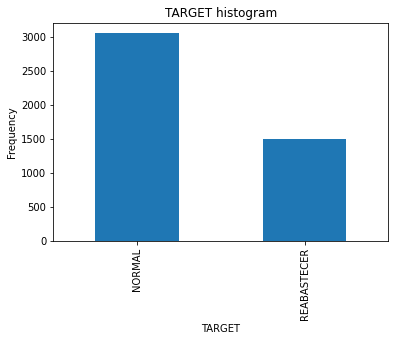

In [8]:
# Visualizando a distribuição das classes (variavel TARGET)
pd.value_counts(treino['TARGET']).plot.bar()
plt.title('TARGET histogram')
plt.xlabel('TARGET')
plt.ylabel('Frequency')

# Visualizando um df com quantidade e percentual da variavel TARGET
tmp = pd.DataFrame(treino['TARGET'].value_counts())
tmp['%'] = 100*tmp['TARGET']/treino.shape[0]
tmp

In [9]:
# Selecionando features para treinamento
X = treino[['Original_473', 'Original_269', 'Zero', 'Maçã-Verde', 'Tangerina', 'Citrus', 'Açaí-Guaraná', 'Pêssego']]

# Selecionando feature target
y = treino['TARGET']

In [10]:
# Resolvendo problema de Overfitting utilizando o OverSampling

# Import dos módulos
from imblearn.over_sampling import SMOTE

# Aplicando a funcao SMOTE
# SMOTE eh um metodo de oversampling. Ele cria exemplos sinteticos da classe minoritaria ao inves de criar copias
sm = SMOTE(random_state=0)
_X, _y = sm.fit_sample(X, y)

Using TensorFlow backend.


In [11]:
# Split dos dados em treino e validacao
X_train, X_valid, y_train, y_valid = train_test_split(_X, _y, test_size=0.2, random_state=133)

# Treinamento com GradientBoosting
model_gbc = GradientBoostingClassifier().fit(X_train, y_train)

# Validacao do modelo
y_pred_val = model_gbc.predict(X_valid)

# Salvando o score
gbc_score = f1_score(y_valid, y_pred_val, average='weighted')

# Matriz de Classificacao
print(classification_report(y_valid, y_pred_val))

# Avaliacao da metrica F1
print('F1_macro   : ', f1_score(y_valid, y_pred_val, average='macro'))
print('F1_micro   : ', f1_score(y_valid, y_pred_val, average='micro'))
print('F1_weighted: ', f1_score(y_valid, y_pred_val, average='weighted'))
print('F1_none    : ', f1_score(y_valid, y_pred_val, average=None))

              precision    recall  f1-score   support

      NORMAL       0.87      0.71      0.78       601
 REABASTECER       0.76      0.90      0.82       619

    accuracy                           0.81      1220
   macro avg       0.82      0.80      0.80      1220
weighted avg       0.82      0.81      0.80      1220

F1_macro   :  0.8036095256919413
F1_micro   :  0.8057377049180328
F1_weighted:  0.8039111573932771
F1_none    :  [0.7831656  0.82405345]


In [12]:
# Split dos dados em treino e validacao
X_train, X_valid, y_train, y_valid = train_test_split(_X, _y, test_size=0.2, random_state=133)

# Treinamento com GradientBoosting
model_lr = LogisticRegression().fit(X_train, y_train)

# Validacao do modelo
y_pred_val = model_lr.predict(X_valid)

# Salvando o score
lr_score = f1_score(y_valid, y_pred_val, average='weighted')

# Matriz de Classificacao
print(classification_report(y_valid, y_pred_val))

# Avaliacao da metrica F1
print('F1_macro   : ', f1_score(y_valid, y_pred_val, average='macro'))
print('F1_micro   : ', f1_score(y_valid, y_pred_val, average='micro'))
print('F1_weighted: ', f1_score(y_valid, y_pred_val, average='weighted'))
print('F1_none    : ', f1_score(y_valid, y_pred_val, average=None))

              precision    recall  f1-score   support

      NORMAL       0.61      0.61      0.61       601
 REABASTECER       0.62      0.62      0.62       619

    accuracy                           0.61      1220
   macro avg       0.61      0.61      0.61      1220
weighted avg       0.61      0.61      0.61      1220

F1_macro   :  0.6138760562433854
F1_micro   :  0.6139344262295082
F1_weighted:  0.6139461002267327
F1_none    :  [0.60912863 0.61862348]


In [13]:
# Split dos dados em treino e validacao
X_train, X_valid, y_train, y_valid = train_test_split(_X, _y, test_size=0.2, random_state=133)

# Treinamento com GradientBoosting
model_knn = KNeighborsClassifier().fit(X_train, y_train)

# Validacao do modelo
y_pred_val = model_knn.predict(X_valid)

# Salvando o score
knn_score = f1_score(y_valid, y_pred_val, average='weighted')

# Matriz de Classificacao
print(classification_report(y_valid, y_pred_val))

# Avaliacao da metrica F1
print('F1_macro   : ', f1_score(y_valid, y_pred_val, average='macro'))
print('F1_micro   : ', f1_score(y_valid, y_pred_val, average='micro'))
print('F1_weighted: ', f1_score(y_valid, y_pred_val, average='weighted'))
print('F1_none    : ', f1_score(y_valid, y_pred_val, average=None))

              precision    recall  f1-score   support

      NORMAL       0.75      0.67      0.71       601
 REABASTECER       0.71      0.78      0.74       619

    accuracy                           0.73      1220
   macro avg       0.73      0.73      0.73      1220
weighted avg       0.73      0.73      0.73      1220

F1_macro   :  0.7250472334682861
F1_micro   :  0.7262295081967213
F1_weighted:  0.7253132452821841
F1_none    :  [0.70701754 0.74307692]


In [14]:
# Split dos dados em treino e validacao
X_train, X_valid, y_train, y_valid = train_test_split(_X, _y, test_size=0.2, random_state=133)

# Treinamento com GradientBoosting
model_dtc = DecisionTreeClassifier().fit(X_train, y_train)

# Validacao do modelo
y_pred_val = model_dtc.predict(X_valid)

# Salvando o score
dtc_score = f1_score(y_valid, y_pred_val, average='weighted')

# Matriz de Classificacao
print(classification_report(y_valid, y_pred_val))

# Avaliacao da metrica F1
print('F1_macro   : ', f1_score(y_valid, y_pred_val, average='macro'))
print('F1_micro   : ', f1_score(y_valid, y_pred_val, average='micro'))
print('F1_weighted: ', f1_score(y_valid, y_pred_val, average='weighted'))
print('F1_none    : ', f1_score(y_valid, y_pred_val, average=None))

              precision    recall  f1-score   support

      NORMAL       0.78      0.76      0.77       601
 REABASTECER       0.77      0.79      0.78       619

    accuracy                           0.77      1220
   macro avg       0.77      0.77      0.77      1220
weighted avg       0.77      0.77      0.77      1220

F1_macro   :  0.7735946488941963
F1_micro   :  0.7737704918032787
F1_weighted:  0.7736877421990046
F1_none    :  [0.76728499 0.77990431]


In [15]:
# Split dos dados em treino e validacao
X_train, X_valid, y_train, y_valid = train_test_split(_X, _y, test_size=0.2, random_state=133)

# Treinamento com GradientBoosting
model_rfc = RandomForestClassifier().fit(X_train, y_train)

# Validacao do modelo
y_pred_val = model_rfc.predict(X_valid)

# Salvando o score
rfc_score = f1_score(y_valid, y_pred_val, average='weighted')

# Matriz de Classificacao
print(classification_report(y_valid, y_pred_val))

# Avaliacao da metrica F1
print('F1_macro   : ', f1_score(y_valid, y_pred_val, average='macro'))
print('F1_micro   : ', f1_score(y_valid, y_pred_val, average='micro'))
print('F1_weighted: ', f1_score(y_valid, y_pred_val, average='weighted'))
print('F1_none    : ', f1_score(y_valid, y_pred_val, average=None))

              precision    recall  f1-score   support

      NORMAL       0.91      0.70      0.79       601
 REABASTECER       0.76      0.94      0.84       619

    accuracy                           0.82      1220
   macro avg       0.84      0.82      0.82      1220
weighted avg       0.84      0.82      0.82      1220

F1_macro   :  0.8165960110315722
F1_micro   :  0.819672131147541
F1_weighted:  0.8169464550954166
F1_none    :  [0.79284369 0.84034833]


In [16]:
# Split dos dados em treino e validacao
X_train, X_valid, y_train, y_valid = train_test_split(_X, _y, test_size=0.2, random_state=133)

# Treinamento com GradientBoosting
model_xgb = XGBClassifier().fit(X_train, y_train)

# Validacao do modelo
y_pred_val = model_xgb.predict(X_valid)

# Salvando o score
xgb_score = f1_score(y_valid, y_pred_val, average='weighted')

# Matriz de Classificacao
print(classification_report(y_valid, y_pred_val))

# Avaliacao da metrica F1
print('F1_macro   : ', f1_score(y_valid, y_pred_val, average='macro'))
print('F1_micro   : ', f1_score(y_valid, y_pred_val, average='micro'))
print('F1_weighted: ', f1_score(y_valid, y_pred_val, average='weighted'))
print('F1_none    : ', f1_score(y_valid, y_pred_val, average=None))

              precision    recall  f1-score   support

      NORMAL       0.85      0.75      0.80       601
 REABASTECER       0.78      0.87      0.83       619

    accuracy                           0.81      1220
   macro avg       0.82      0.81      0.81      1220
weighted avg       0.82      0.81      0.81      1220

F1_macro   :  0.8112449066595321
F1_micro   :  0.8122950819672131
F1_weighted:  0.811452633643469
F1_none    :  [0.79716563 0.82532418]


In [17]:
# Prepara a lista de resultados
metricas = [(gbc_score),(lr_score),(knn_score),(dtc_score),(rfc_score),(xgb_score)]

# Cria o dataframe
df_metricas = pd.DataFrame(metricas, 
                           columns = ['Accuracy'], 
                           index = ['GBC', 'LR', 'KNN', 'DTC', 'RFC', 'XGB']) 

# Visualiza o resultado
df_metricas

,Accuracy
GBC,0.803911
LR,0.613946
KNN,0.725313
DTC,0.773688
RFC,0.816946
XGB,0.811453


# AUTOML com H20

In [18]:
# Importando as bibliotecas
import h2o
from h2o.automl import H2OAutoML

# Inicializando o cluster
h2o.init()
h2o.cluster().show_status()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,18 days 19 hours 44 mins
H2O_cluster_timezone:,America/Sao_Paulo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.1
H2O_cluster_version_age:,26 days
H2O_cluster_name:,H2O_from_python_unimed_arnacy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,14.15 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


H2O_cluster_uptime:,18 days 19 hours 44 mins
H2O_cluster_timezone:,America/Sao_Paulo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.1
H2O_cluster_version_age:,26 days
H2O_cluster_name:,H2O_from_python_unimed_arnacy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,14.15 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


In [19]:
# Importando os datasets   
df_treino = h2o.H2OFrame(treino)

# Convertendo a coluna target em fator
df_treino['TARGET'] = df_treino['TARGET'].asfactor()

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [23]:
# Indicando as colunas preditoras e a target
X = df_treino.drop(['TARGET'], axis = 1).columns
y = 'TARGET'

# Executa o AutoML para 20 modelos
aml = H2OAutoML(max_models=20, seed=133, balance_classes=True, verbosity='info')
aml.train(x=X, y=y, training_frame=df_treino)

AutoML progress: |
18:31:55.871: Project: AutoML_20200905_183155871
18:31:55.871: Setting stopping tolerance adaptively based on the training frame: 0.014829876109507997
18:31:55.871: Build control seed: 133
18:31:55.871: training frame: Frame key: automl_training_py_1_sid_b885    cols: 9    rows: 4547  chunks: 1    size: 38141  checksum: -223911394653192
18:31:55.871: validation frame: NULL
18:31:55.872: leaderboard frame: NULL
18:31:55.872: blending frame: NULL
18:31:55.872: response column: TARGET
18:31:55.872: fold column: null
18:31:55.872: weights column: null
18:31:55.872: Loading execution steps: [{XGBoost : defaults}, {GLM : defaults}, {DRF : [def_1]}, {GBM : defaults}, {DeepLearning : defaults}, {DRF : [XRT]}, {XGBoost : grids}, {GBM : grids}, {DeepLearning : grids}, {GBM : [lr_annealing]}, {XGBoost : [lr_search]}, {StackedEnsemble : defaults}]
18:31:55.872: AutoML job created: 2020.09.05 18:31:55.871
18:31:55.873: AutoML build started: 2020.09.05 18:31:55.873
18:31:55.873: A

In [24]:
# AutoML Leaderboard
lb = aml.leaderboard

# Exibir as colunas do resultado dos modelos
lb.head(rows=lb.nrows)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
XGBoost_3_AutoML_20200905_183155,0.85135,0.428701,0.618816,0.15824,0.383267,0.146894
XGBoost_grid__1_AutoML_20200905_183155_model_1,0.851028,0.426427,0.619798,0.157766,0.382406,0.146234
GBM_1_AutoML_20200905_183155,0.848824,0.417379,0.619347,0.158902,0.382367,0.146205
GBM_grid__1_AutoML_20200905_183155_model_2,0.848529,0.415963,0.613102,0.157936,0.384745,0.148029
StackedEnsemble_BestOfFamily_AutoML_20200905_183155,0.847885,0.430059,0.609863,0.157256,0.38367,0.147203
XGBoost_grid__1_AutoML_20200905_183155_model_4,0.847473,0.420131,0.606534,0.154924,0.377848,0.142769
XGBoost_grid__1_AutoML_20200905_183155_model_2,0.847222,0.399549,0.614698,0.155258,0.373238,0.139306
GBM_grid__1_AutoML_20200905_183155_model_1,0.846957,0.403377,0.610052,0.156764,0.378993,0.143636
GBM_2_AutoML_20200905_183155,0.846747,0.419263,0.615128,0.158252,0.383794,0.147298
GBM_5_AutoML_20200905_183155,0.846569,0.418114,0.618191,0.166299,0.381918,0.145861


In [25]:
# Detalhes do melhor modelo
aml.leader

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20200905_183155


Model Summary: 


,,number_of_trees
0,,36.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.08860762551045322
RMSE: 0.2976703302488396
LogLoss: 0.28886855895432384
Mean Per-Class Error: 0.10372022733992581
AUC: 0.9563536909885344
AUCPR: 0.9002925890349864
Gini: 0.9127073819770688

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44455873114722116: 


,,NORMAL,REABASTECER,Error,Rate
0,NORMAL,2631.0,419.0,0.1374,(419.0/3050.0)
1,REABASTECER,110.0,1387.0,0.0735,(110.0/1497.0)
2,Total,2741.0,1806.0,0.1163,(529.0/4547.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.444559,0.839843,217.0
1,max f2,0.374881,0.911241,247.0
2,max f0point5,0.556188,0.835149,165.0
3,max accuracy,0.515785,0.887838,181.0
4,max precision,0.984998,1.000000,0.0
5,max recall,0.238327,1.000000,296.0
6,max specificity,0.984998,1.000000,0.0
7,max absolute_mcc,0.444559,0.757884,217.0
8,max min_per_class_accuracy,0.476500,0.882295,201.0
9,max mean_per_class_accuracy,0.417430,0.896280,229.0



Gains/Lift Table: Avg response rate: 32,92 %, avg score: 32,77 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010117,0.917432,3.037408,3.037408,1.000000,0.937937,1.000000,0.937937,0.030728,0.030728,203.740815,203.740815,0.030728
1,2,0.020013,0.893632,3.037408,3.037408,1.000000,0.906861,1.000000,0.922570,0.030060,0.060788,203.740815,203.740815,0.060788
2,3,0.030130,0.873369,3.037408,3.037408,1.000000,0.883656,1.000000,0.909504,0.030728,0.091516,203.740815,203.740815,0.091516
3,4,0.040026,0.859545,2.902412,3.004030,0.955556,0.866908,0.989011,0.898972,0.028724,0.120240,190.241223,200.403004,0.119585
4,5,0.050143,0.843891,2.971378,2.997442,0.978261,0.852021,0.986842,0.889500,0.030060,0.150301,197.137754,199.744225,0.149317
5,6,0.100066,0.757091,2.796556,2.897220,0.920705,0.800526,0.953846,0.845110,0.139613,0.289913,179.655640,189.722008,0.283028
6,7,0.149989,0.695225,2.595847,2.796910,0.854626,0.723620,0.920821,0.804673,0.129593,0.419506,159.584661,179.690956,0.401801
7,8,0.200132,0.643723,2.571139,2.740343,0.846491,0.667952,0.902198,0.770418,0.128925,0.548430,157.113935,174.034296,0.519250
8,9,0.299978,0.550326,2.261330,2.580906,0.744493,0.598397,0.849707,0.713161,0.225785,0.774215,126.133030,158.090619,0.707002
9,10,0.400044,0.437797,1.535393,2.319384,0.505495,0.493672,0.763606,0.658259,0.153641,0.927856,53.539313,131.938423,0.786872




ModelMetricsBinomial: xgboost
** Reported on cross-validation data. **

MSE: 0.14689378784631002
RMSE: 0.38326725381424126
LogLoss: 0.4287012713888211
Mean Per-Class Error: 0.1582396486962998
AUC: 0.8513499129406354
AUCPR: 0.6188163840289967
Gini: 0.7026998258812709

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1538543775677681: 


,,NORMAL,REABASTECER,Error,Rate
0,NORMAL,2099.0,951.0,0.3118,(951.0/3050.0)
1,REABASTECER,7.0,1490.0,0.0047,(7.0/1497.0)
2,Total,2106.0,2441.0,0.2107,(958.0/4547.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.153854,0.756729,311.0
1,max f2,0.153854,0.883853,311.0
2,max f0point5,0.317567,0.665122,266.0
3,max accuracy,0.237763,0.789971,290.0
4,max precision,0.664920,0.637549,112.0
5,max recall,0.098761,1.000000,328.0
6,max specificity,0.992371,0.999672,0.0
7,max absolute_mcc,0.153854,0.644168,311.0
8,max min_per_class_accuracy,0.414610,0.771803,228.0
9,max mean_per_class_accuracy,0.153854,0.841760,311.0



Gains/Lift Table: Avg response rate: 32,92 %, avg score: 32,36 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010117,0.935862,1.716796,1.716796,0.565217,0.953627,0.565217,0.953627,0.017368,0.017368,71.679591,71.679591,0.010811
1,2,0.020013,0.909303,1.687449,1.702284,0.555556,0.922038,0.560440,0.938006,0.016700,0.034068,68.744897,70.228369,0.020953
2,3,0.030130,0.890623,1.980918,1.795840,0.652174,0.900339,0.591241,0.925359,0.020040,0.054108,98.091836,79.583985,0.035748
3,4,0.040026,0.865648,2.024939,1.852485,0.666667,0.877900,0.609890,0.913624,0.020040,0.074148,102.493877,85.248519,0.050870
4,5,0.050143,0.846549,2.112980,1.905041,0.695652,0.856275,0.627193,0.902054,0.021376,0.095524,111.297958,90.504108,0.067656
5,6,0.100066,0.756874,1.846530,1.875850,0.607930,0.799428,0.617582,0.850854,0.092184,0.187709,84.653006,87.584987,0.130660
6,7,0.149989,0.689602,1.980337,1.910628,0.651982,0.722114,0.629032,0.808003,0.098864,0.286573,98.033659,91.062771,0.203622
7,8,0.200132,0.626979,1.945007,1.919241,0.640351,0.657424,0.631868,0.770276,0.097528,0.384102,94.500697,91.924141,0.274265
8,9,0.299978,0.529219,1.833149,1.890586,0.603524,0.577793,0.622434,0.706209,0.183033,0.567134,83.314941,89.058616,0.398282
9,10,0.400044,0.423358,1.909228,1.895249,0.628571,0.476924,0.623969,0.648856,0.191049,0.758183,90.922798,89.524918,0.533921




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.79348516,0.011782893,0.8032967,0.8065934,0.79427946,0.779978,0.78327835
1,auc,0.85212225,0.011142789,0.86516154,0.86103517,0.84909195,0.8480919,0.83723074
2,aucpr,0.6222235,0.047805633,0.6911854,0.6466391,0.61443275,0.5736678,0.5851924
3,err,0.20651482,0.011782893,0.1967033,0.1934066,0.20572057,0.22002201,0.21672167
4,err_count,187.8,10.616026,179.0,176.0,187.0,200.0,197.0
5,f0point5,0.6655521,0.029002164,0.6997886,0.6901978,0.659945,0.6307174,0.64711154
6,f1,0.7577703,0.025248503,0.78715813,0.7772152,0.7549148,0.7237569,0.74580646
7,f2,0.87992567,0.018909803,0.8994565,0.8893395,0.88181263,0.84899545,0.8800244
8,lift_top_group,1.7688286,0.2823167,1.6396396,1.4583334,2.194138,1.6648352,1.8871973
9,logloss,0.42870405,0.010317988,0.41722304,0.4275427,0.42224038,0.43240982,0.44410434



See the whole table with table.as_data_frame()

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2020-09-05 18:32:00,0.544 sec,0.0,0.500000,0.693147,0.500000,0.329228,1.000000,0.670772
1,,2020-09-05 18:32:00,0.831 sec,5.0,0.373661,0.444288,0.892917,0.741895,2.641224,0.193534
2,,2020-09-05 18:32:00,0.857 sec,10.0,0.346508,0.378246,0.905803,0.779278,2.839316,0.180779
3,,2020-09-05 18:32:00,0.877 sec,15.0,0.334176,0.352099,0.920760,0.812685,2.971378,0.166923
4,,2020-09-05 18:32:00,0.893 sec,20.0,0.323860,0.331596,0.932283,0.838682,2.971378,0.139213
5,,2020-09-05 18:32:00,1.037 sec,25.0,0.315928,0.316721,0.939351,0.859105,3.037408,0.141192
6,,2020-09-05 18:32:00,1.061 sec,30.0,0.306558,0.302185,0.948493,0.880406,3.037408,0.120959
7,,2020-09-05 18:32:01,1.156 sec,35.0,0.298642,0.290399,0.955701,0.898551,3.037408,0.119639
8,,2020-09-05 18:32:01,1.173 sec,36.0,0.297670,0.288869,0.956354,0.900293,3.037408,0.116340



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,Original_269,833.378845,1.000000,0.153834
1,Original_473,713.858154,0.856583,0.131772
2,Zero,684.819031,0.821738,0.126412
3,Tangerina,683.889709,0.820623,0.126240
4,Pêssego,679.395203,0.815230,0.125410
5,Açaí-Guaraná,657.387390,0.788822,0.121348
6,Citrus,592.276733,0.710693,0.109329
7,Maçã-Verde,572.374084,0.686811,0.105655


In [43]:
df_teste = h2o.H2OFrame(teste)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [44]:
# Gerar as previsoes no dataset de teste
preds = aml.leader.predict(df_teste)

# Salvar o resultado no dataset de teste
result = preds[:,0]
df_teste['TARGET'] = result

xgboost prediction progress: |████████████████████████████████████████████| 100%


In [45]:
# Gravar o arquivo de submissão ao Desafio
h2o.export_file(df_teste,'results_desafio_7.csv')

Export File progress: |███████████████████████████████████████████████████| 100%


,TARGET,%
NORMAL,593,29650.0
REABASTECER,391,19550.0


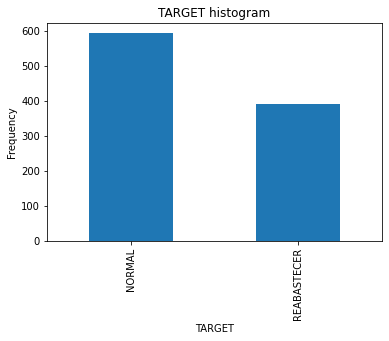

In [35]:

# Carregando o dataset de testes 
tmp  = pd.read_csv(r'results_desafio_7.csv')

# Visualizando a distribuição das classes (variavel TARGET)
pd.value_counts(tmp['TARGET']).plot.bar()
plt.title('TARGET histogram')
plt.xlabel('TARGET')
plt.ylabel('Frequency')

# Visualizando um df com quantidade e percentual da variavel TARGET
tmp = pd.DataFrame(tmp['TARGET'].value_counts())
tmp['%'] = 100*tmp['TARGET']/tmp.shape[0]
tmp